In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [30]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [10]:
PATH = "Data/USACorona/"

In [12]:
!ls {PATH}

582631_1175383_compressed_UNCOVER_USAFacts_confirmed-covid-19-cases-in-us-by-state-and-county.csv.zip
582631_1175383_compressed_UNCOVER_USAFacts_confirmed-covid-19-deaths-in-us-by-state-and-county.csv.zip
cases.csv
deaths.csv


In [31]:
latest_date = datetime.today()- timedelta(days=2)
latest_date = latest_date.strftime('%m/%d/%y')[1:]

In [43]:
df_Death = pd.read_csv(f'{PATH}deaths.csv')[['countyFIPS', latest_date]]
df_Death = df_Death.rename(columns={'countyFIPS': 'county_fips',
                                                  latest_date: 'deaths'}).set_index('county_fips')
df_Cases = pd.read_csv(f'{PATH}cases.csv')[['countyFIPS', 'County Name', 'State', latest_date]]
df_Cases = df_Cases.rename(columns={'countyFIPS': 'county_fips',
                                                  latest_date: 'confirmed'}).set_index('county_fips')
df_Pop = pd.read_csv(f'{PATH}population.csv')[['countyFIPS', 'population']]
df_Pop = df_Pop.rename(columns={'countyFIPS': 'county_fips'}).set_index('county_fips')


In [44]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [45]:
display_all(df_Death.tail().T)

county_fips,56037,56039,56041,56043,56045
deaths,0,1,0,5,0


In [46]:
display_all(df_Cases.tail().T)

county_fips,56037,56039,56041,56043,56045
County Name,Sweetwater County,Teton County,Uinta County,Washakie County,Weston County
State,WY,WY,WY,WY,WY
confirmed,81,119,167,39,1


In [47]:
display_all(df_Pop.tail().T)

county_fips,56037,56039,56041,56043,56045
population,42343,23464,20226,7805,6927


In [48]:
display_all(df_Death.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
deaths,3195.0,39.041002,262.551245,0.0,0.0,1.0,9.0,7020.0


In [49]:
display_all(df_Cases.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
County Name,3195,1882,Statewide Unallocated,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,3195,51,TX,255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confirmed,3195,NaN,NaN,NaN,780.432,3852.06,0,16,70,305,95371


In [50]:
display_all(df_Pop.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
population,3195.0,102735.374961,330947.685703,0.0,10399.5,25127.0,66941.5,10039107.0


In [52]:
df = df_Cases.join(df_Death)
df = df.join(df_Pop)

In [54]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
County Name,130645,1882,Statewide Unallocated,127500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,130645,51,TX,2804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confirmed,130645,NaN,NaN,NaN,308.452,1127.29,0,0,2,53,95371
deaths,130645,NaN,NaN,NaN,12.6028,60.7745,0,0,0,0,7020
population,130644,NaN,NaN,NaN,2512.47,54125.3,0,0,0,0,1.00391e+07


In [56]:
df = df[df.population>0]
del df_Cases, df_Death, df_Pop

In [57]:
df['mortality'] = df['deaths']/ df['confirmed']
df['mortality'] = df['mortality'].fillna(0)

In [58]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
County Name,3142,1878,Washington County,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,3142,51,TX,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confirmed,3142,NaN,NaN,NaN,788.87,3881.97,0,16,71,309.5,95371
deaths,3142,NaN,NaN,NaN,39.4968,264.671,0,0,1,9,7020
population,3142,NaN,NaN,NaN,104468,333457,86,10902.5,25726,68072.8,1.00391e+07
mortality,3142,NaN,NaN,NaN,0.0292437,0.0424986,0,0,0.014033,0.0431833,0.5


In [59]:
df['deaths_per_million'] = df['deaths'] * 1000000/ df['population']
df['cases_per_million'] = df['confirmed'] * 1000000/ df['population']

df['likely_infected_high'] = np.round(df['confirmed'] * 80/ df['population'], 2)
df['likely_infected_high'] = np.clip(df['likely_infected_high'], 0, 1)
df['likely_infected_low'] = np.round(df['confirmed'] * 28/ df['population'], 2)
df['likely_infected_low'] = np.clip(df['likely_infected_low'], 0, 1)

df['county_state'] = df['County Name'] + ', ' + df['State']

In [60]:
display_all(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
County Name,3142,1878,Washington County,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,3142,51,TX,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
confirmed,3142,NaN,NaN,NaN,788.87,3881.97,0,16,71,309.5,95371
deaths,3142,NaN,NaN,NaN,39.4968,264.671,0,0,1,9,7020
population,3142,NaN,NaN,NaN,104468,333457,86,10902.5,25726,68072.8,1.00391e+07
mortality,3142,NaN,NaN,NaN,0.0292437,0.0424986,0,0,0.014033,0.0431833,0.5
deaths_per_million,3142,NaN,NaN,NaN,168.386,340.931,0,0,42.7219,172.523,3783.85
cases_per_million,3142,NaN,NaN,NaN,4826.95,7496.02,0,1070.82,2505.95,5697.75,130805
likely_infected_high,3142,NaN,NaN,NaN,0.315481,0.301812,0,0.09,0.2,0.4575,1
likely_infected_low,3142,NaN,NaN,NaN,0.130054,0.170102,0,0.03,0.07,0.16,1


Summary Statistic of Percetnage of Population Likely Infected across counties: 

count    3142.000000
mean        0.315481
std         0.301812
min         0.000000
25%         0.090000
50%         0.200000
75%         0.457500
max         1.000000
Name: likely_infected_high, dtype: float64


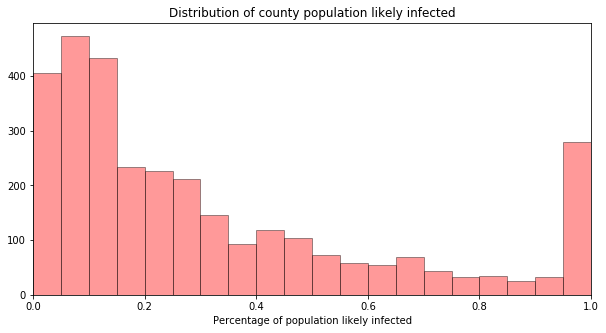

In [61]:
plt.figure(figsize=(10,5))

sns.distplot(df.likely_infected_high, hist=True, kde=False, color = 'red', 
             hist_kws={'edgecolor':'black', 'linewidth':1},
             kde_kws={'linewidth': 2})

print('Summary Statistic of Percetnage of Population Likely Infected across counties: \n')
print(df.likely_infected_high.describe())

plt.xlim(0, 1)
plt.title('Distribution of county population likely infected')
plt.xlabel('Percentage of population likely infected')

plt.show()

In [62]:
train_cats(df)

In [64]:
display_all(df.isnull().sum().sort_index()/len(df))

County Name             0.0
State                   0.0
cases_per_million       0.0
confirmed               0.0
county_state            0.0
deaths                  0.0
deaths_per_million      0.0
likely_infected_high    0.0
likely_infected_low     0.0
mortality               0.0
population              0.0
dtype: float64

In [81]:
df.reset_index()

,county_fips,State,confirmed,deaths,population,likely_infected_high,likely_infected_low
0,1001,1,498,12,55869.0,0.71,0.25
1,1003,1,555,10,223234.0,0.20,0.07
2,1005,1,317,1,24686.0,1.00,0.36
3,1007,1,161,1,22394.0,0.58,0.20
4,1009,1,188,1,57826.0,0.26,0.09
...,...,...,...,...,...,...,...
3137,56037,50,81,0,42343.0,0.15,0.05
3138,56039,50,119,1,23464.0,0.41,0.14
3139,56041,50,167,0,20226.0,0.66,0.23
3140,56043,50,39,5,7805.0,0.40,0.14


In [69]:
df.State = df.State.cat.codes

In [73]:
df_true, y, nas = proc_df(df, 'deaths')

In [80]:
del df['cases_per_million']

In [82]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9982074091560507

In [84]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 3141  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df_true, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1, 10), (1,), (3141, 10))